In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 68% 41.0M/60.3M [00:00<00:00, 212MB/s]
100% 60.3M/60.3M [00:00<00:00, 219MB/s]


In [ ]:
!unzip /content/fer2013.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/Training_65242339.jpg  
  inflating: /content/train/sad/Training_65267116.jpg  
  inflating: /content/train/sad/Training_65275626.jpg  
  inflating: /content/train/sad/Training_6529266.jpg  
  inflating: /content/train/sad/Training_65329617.jpg  
  inflating: /content/train/sad/Training_65338712.jpg  
  inflating: /content/train/sad/Training_65338797.jpg  
  inflating: /content/train/sad/Training_65387162.jpg  
  inflating: /content/train/sad/Training_65404494.jpg  
  inflating: /content/train/sad/Training_65426218.jpg  
  inflating: /content/train/sad/Training_65430136.jpg  
  inflating: /content/train/sad/Training_65437377.jpg  
  inflating: /content/train/sad/Training_6545735.jpg  
  inflating: /content/train/sad/Training_65463385.jpg  
  inflating: /content/train/sad/Training_65473985.jpg  
  inflating: /content/train/sad/Training_65502829.jpg  
  inflating: /content/train/sad/Training_65505359.jpg  

# Import Packages

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model

# Setting up Directory to save model data.

In [ ]:
os.makedirs('test_dir', exist_ok=True)

In [ ]:
project_name = 'Emotion_Detection'

model_names = [
    'Custom_CNN_From_Scratch',
    'Custom_CNN_With_Augmentation'
]

base_dir = '/content/'

# Create the project directory
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/Emotion_Detection


# Data Cleaning

In [ ]:
# Define the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

data_dir = '/content/train'

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)

        try:
            file_type = imghdr.what(file_path)

            if file_type not in image_exts:
                print(f'Image not in ext list {file_path}')
                os.remove(file_path)
            else:
                img = cv2.imread(file_path)

        except Exception as e:
            print(f'Issue with file {file_path}. Error: {e}')
            os.remove(file_path)

# Data Analysis

In [ ]:
def count_files_in_subdirs(directory, set_name):
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            counts[item] = len(os.listdir(item_path))

    df = pd.DataFrame(counts, index=[set_name])
    return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

       surprise  happy  neutral  angry   sad  fear  disgust
train      3171   7215     4965   3995  4830  4097      436
      surprise  happy  neutral  angry   sad  fear  disgust
test       831   1774     1233    958  1247  1024      111


<Axes: >

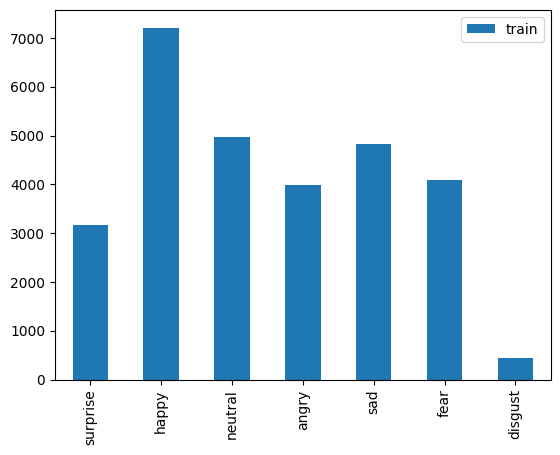

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

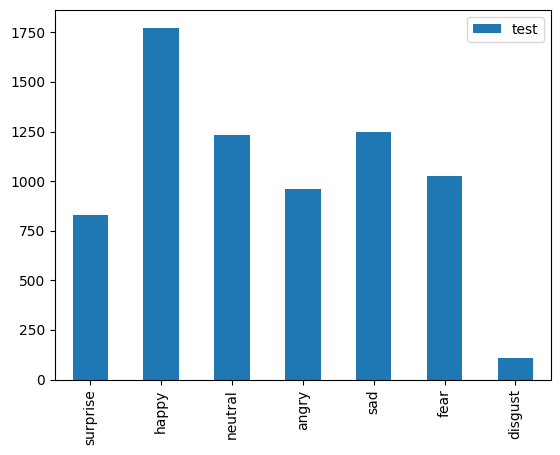

In [ ]:
test_count.transpose().plot(kind='bar')

# Plotting one image from each emotion.

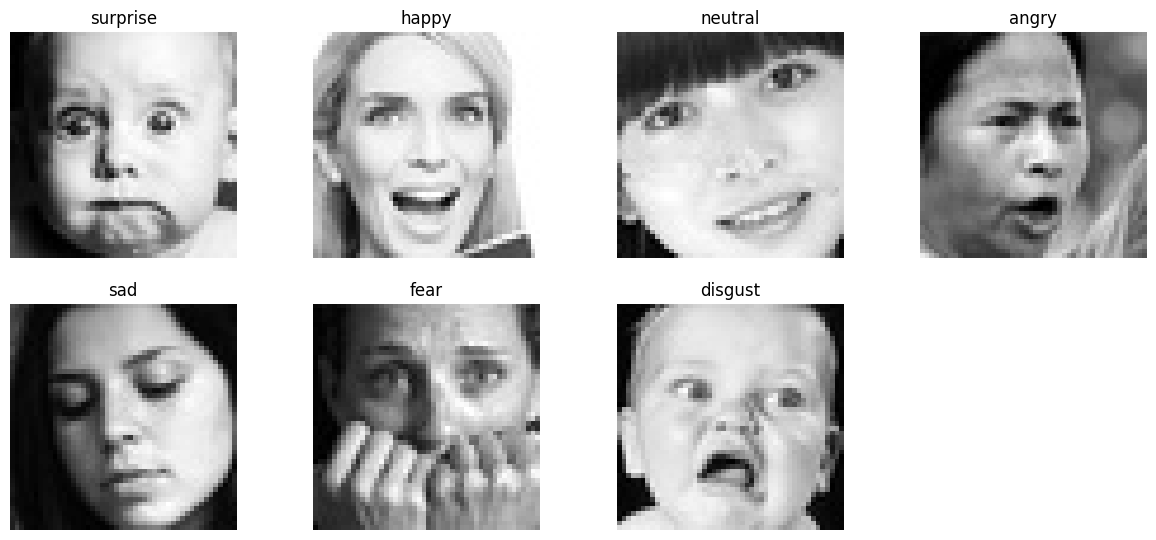

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

# Plotting random images from given directory

In [ ]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    selected_images = random.sample(image_filenames, num_images)

    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

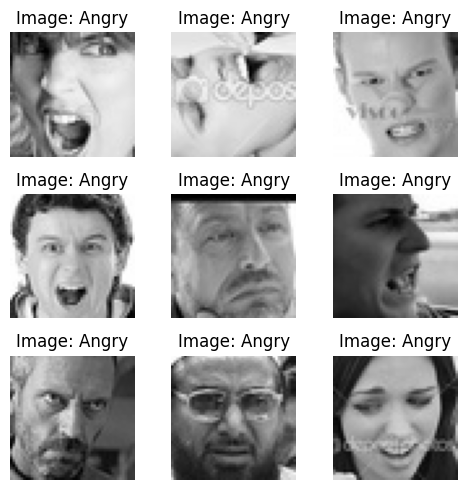

In [ ]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

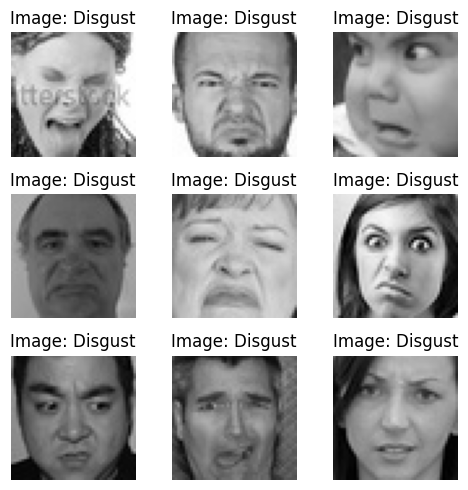

In [ ]:
disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path, class_name = 'Disgust')

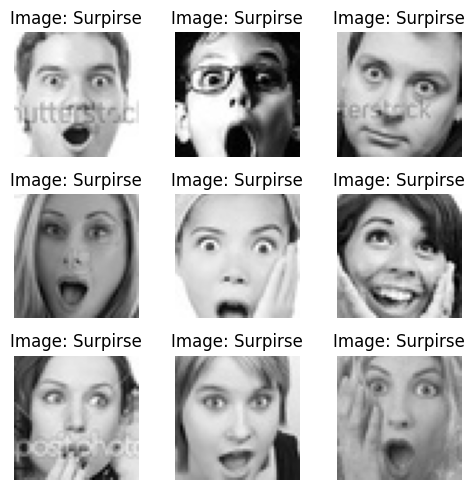

In [ ]:
surpirse_directory_path = '/content/train/surprise'
plot_images_from_directory(surpirse_directory_path, class_name = 'Surpirse')

# Checking shapes and channels.

In [ ]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2

img = cv2.imread(image)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48, 3)


In [ ]:
import cv2

image_path = '/content/train/angry/Training_10118481.jpg'

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if img is not None:
    print("Shape:", img.shape)
else:
    print("The image could not be loaded. Please check the path and file permissions.")

Shape: (48, 48)


# Model 1 : Custom CNN from Scratch

## Initializing the ImageGenerators

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Accessing class labels for the training, validation and testing data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="glorot_uniform", padding='same', input_shape=(48, 48, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(7))
model.add(Activation('softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 22, 22, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 22, 22, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 11, 11, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 11, 11, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 5, 5, 512)           │              

 Total params: 17,046,535 (65.03 MB)

 Trainable params: 17,044,871 (65.02 MB)

 Non-trainable params: 1,664 (6.50 KB)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

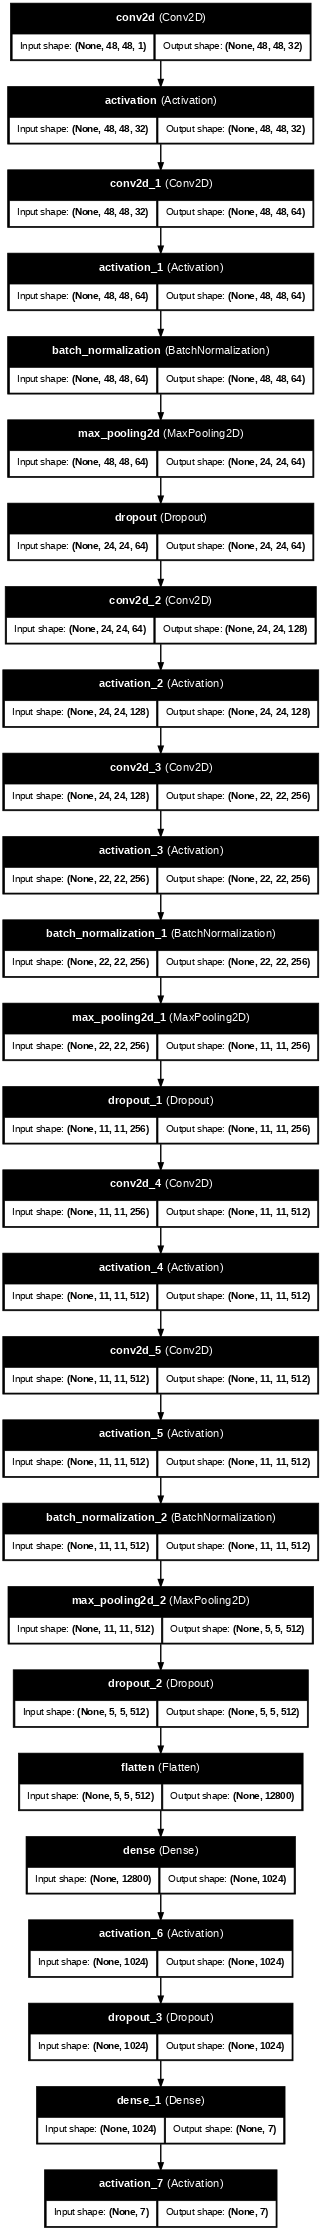

In [ ]:
plot_model(model, to_file = '/content/Emotion_Detection/Custom_CNN_From_Scratch/Architecture.png',
           show_shapes=True, show_layer_names=True, dpi=50)

# Understanding Callbacks

In [ ]:
# File path for the model checkpoint
cnn_path = '/content/Emotion_Detection/Custom_CNN_From_Scratch'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path, name)
chk_path

'/content/Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras'

In [ ]:
# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [ ]:
# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [ ]:
# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [ ]:
# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [ ]:
# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

# Model Training

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2514 - loss: 13.3060
Epoch 1: val_loss improved from inf to 12.71428, saving model to /content/Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 56s 112ms/step - accuracy: 0.2515 - loss: 13.3035 - val_accuracy: 0.1684 - val_loss: 12.7143 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3436 - loss: 10.7062
Epoch 2: val_loss improved from 12.71428 to 9.54606, saving model to /content/Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 55s 71ms/step - accuracy: 0.3437 - loss: 10.7048 - val_accuracy: 0.3816 - val_loss: 9.5461 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3804 - loss: 8.6504
Epoch 3: val_loss improved from 9.54606 to 7.34140, saving model to /content/Emotion_Detection/Custom_CNN_From_Scratch/Custom_CNN_model.keras
359/359 ━━━━━━━━━━━━━━━━━━

# Plotting Performance Metrics

In [ ]:
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.

    Parameters:
    - history: A Keras History object. Contains the logs from the training process.

    Returns:
    - None. Displays the matplotlib plots for training/validation accuracy and loss.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

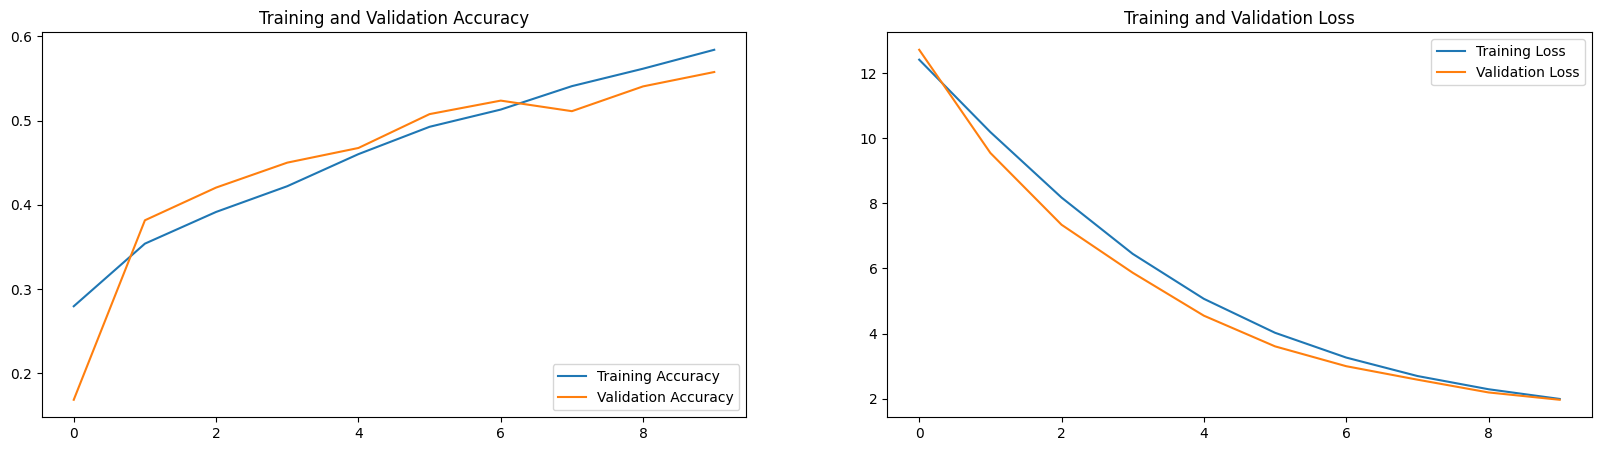

In [ ]:
plot_training_history(history)

# Model Evaluation

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.6507 - loss: 1.7344
113/113 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.5602 - loss: 1.9693
final train accuracy = 65.26 , validation accuracy = 56.09


# Plotting Confusion Matrix

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


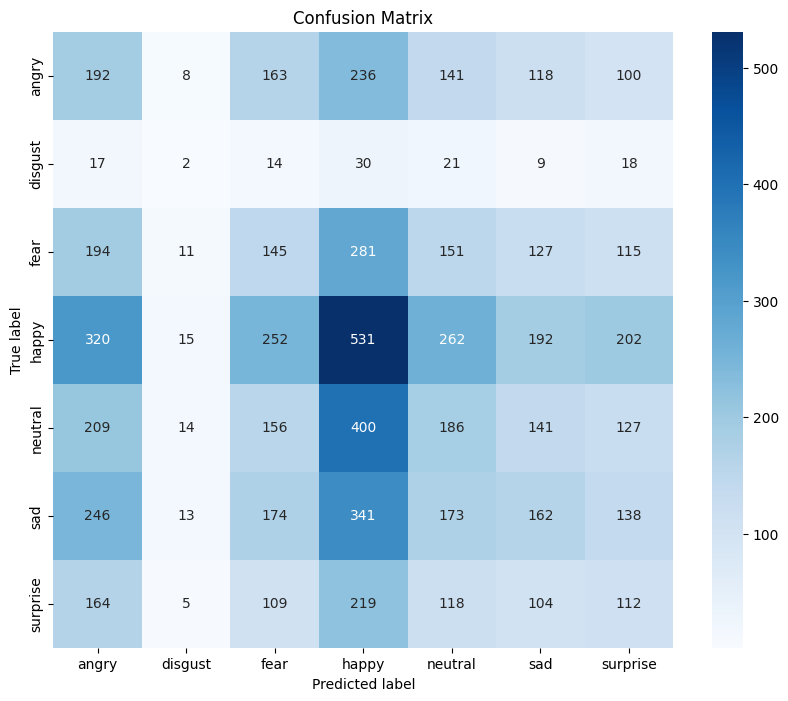

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.20      0.17       958
     disgust       0.03      0.02      0.02       111
        fear       0.14      0.14      0.14      1024
       happy       0.26      0.30      0.28      1774
     neutral       0.18      0.15      0.16      1233
         sad       0.19      0.13      0.15      1247
    surprise       0.14      0.13      0.14       831

    accuracy                           0.19      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.19      0.18      7178



# Making Predictions

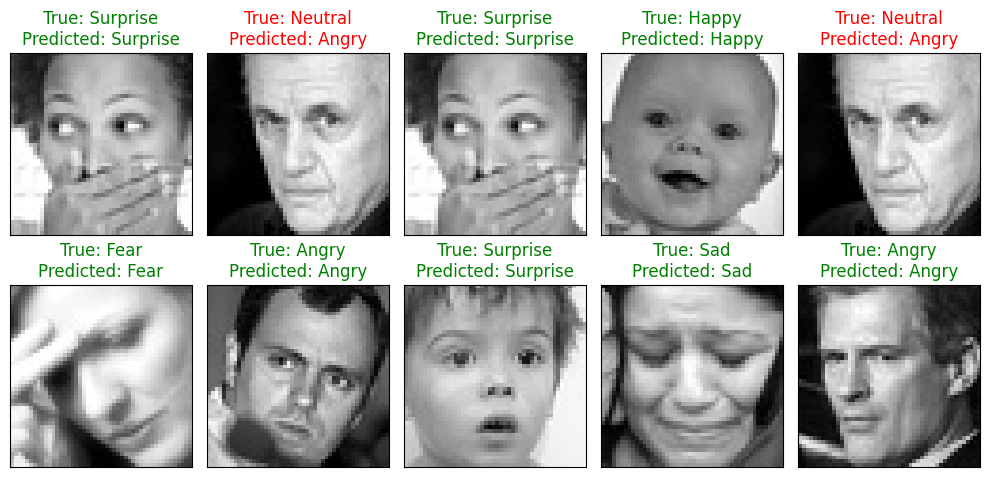

In [ ]:
# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

batch_size = test_generator.batch_size

Random_batch = np.random.randint(0, len(test_generator) - 1)

Random_Img_Index = np.random.randint(0, batch_size, 10)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    ax.imshow(Random_Img.squeeze(), cmap='gray')

    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# Model 2: Image Augmentation

In [ ]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

img_width, img_height = 48, 48
batch_size = 64
epochs = 10
num_classes = 7


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2)

test_data_generator = ImageDataGenerator(rescale=1./255)


train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


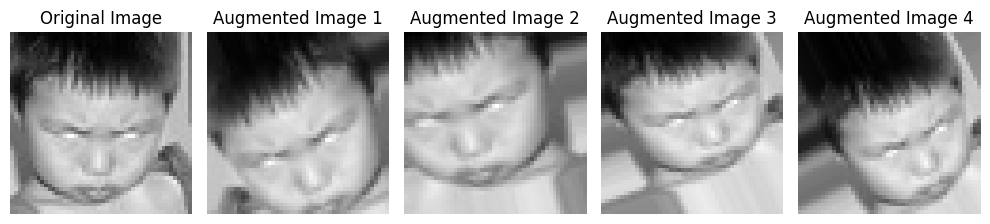

In [ ]:
image_path = '/content/train/angry/Training_10118481.jpg'

img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

# Same CNN Model as above

In [ ]:
img_width, img_height = 48, 48
classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(48, 48, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


cnn_path = '/content/Emotion_Detection/Custom_CNN_With_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=callbacks)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2032 - loss: 13.4841
Epoch 1: val_loss improved from inf to 14.73855, saving model to /content/Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 121ms/step - accuracy: 0.2032 - loss: 13.4815 - val_accuracy: 0.1160 - val_loss: 14.7385 - learning_rate: 1.0000e-04
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2397 - loss: 10.8506
Epoch 2: val_loss improved from 14.73855 to 10.01164, saving model to /content/Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN_augmented_model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 90ms/step - accuracy: 0.2397 - loss: 10.8491 - val_accuracy: 0.2080 - val_loss: 10.0116 - learning_rate: 1.0000e-04
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2444 - loss: 8.7212
Epoch 3: val_loss improved from 10.01164 to 7.54187, saving model to /content/Emotion_Detection/Custom_CNN_With_Augmentation/Custom_CNN

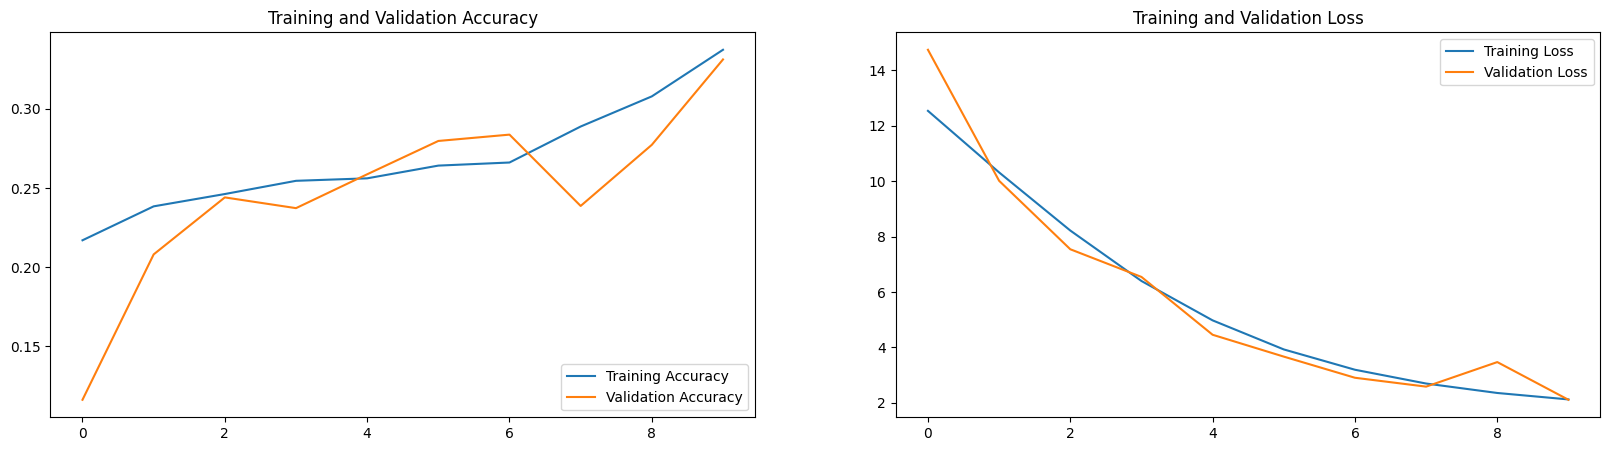

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

359/359 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.3334 - loss: 2.1118
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3431 - loss: 2.1108
final train accuracy = 33.09 , validation accuracy = 35.09


113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step


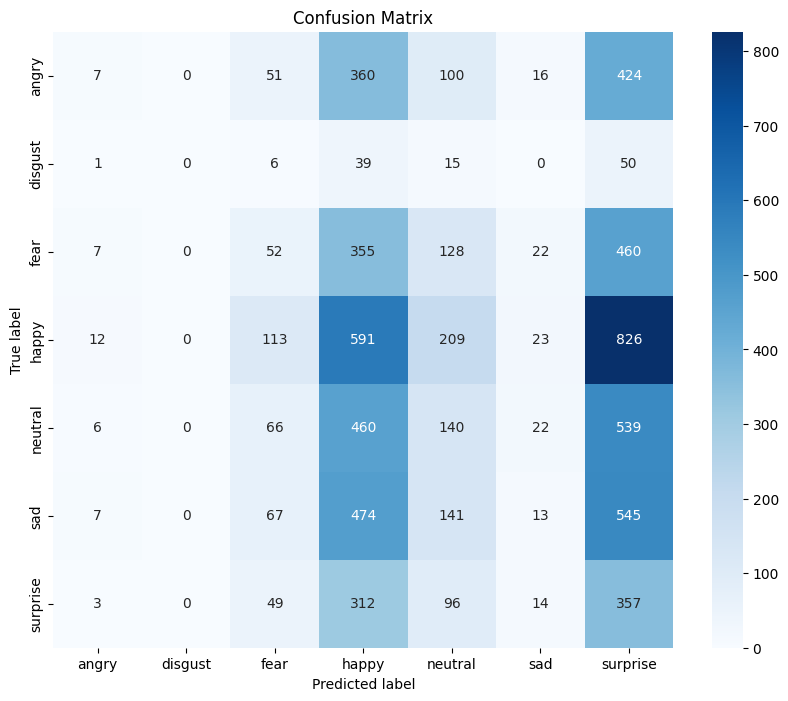

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.16      0.01      0.01       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.05      0.07      1024
       happy       0.23      0.33      0.27      1774
     neutral       0.17      0.11      0.14      1233
         sad       0.12      0.01      0.02      1247
    surprise       0.11      0.43      0.18       831

    accuracy                           0.16      7178
   macro avg       0.13      0.13      0.10      7178
weighted avg       0.16      0.16      0.13      7178

